# Unsupervised learning with k-Means

In [1]:
from pymongo import MongoClient
from gensim.models import Word2Vec
import gensim
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
from itertools import combinations
import community
from collections import defaultdict
import randomcolor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.special import comb
from scipy.spatial.distance import pdist

## Load reduced-dim vectors and full-dim vectors 

### 300-dimension vectors

In [5]:
inclusion_vectors = pickle.load(open("vectorized_criteria.p", 'rb'))

In [4]:
inclusion_df.shape

(11298, 300)

In [6]:
drop_index = np.argwhere(np.isnan(inclusion_vectors))
drop_row_index = drop_index[:,0]

In [7]:
inclusion_df = pd.DataFrame(inclusion_vectors)
inclusion_df = inclusion_df.dropna()
inclusion_df.shape

(11235, 300)

### 86-dimension vectors 

In [47]:
reduced_86D_vectors = pickle.load(open("86D_threshhold_pca_features.p", 'rb'))

In [48]:
drop_index = np.argwhere(np.isnan(reduced_86D_vectors))
drop_row_index = drop_index[:,0]

In [49]:
reduced_86D_vectors = pd.DataFrame(reduced_86D_vectors)
reduced_86D_vectors = reduced_86D_vectors.dropna()
reduced_86D_vectors.shape

(11235, 86)

### 2-dimension vectors 

In [12]:
reduced_2D_vectors = pickle.load(open("2D_pcafeatures.p", 'rb'))

## Clustering on the word2vec'd 300 dimensions without dimensionality reduction

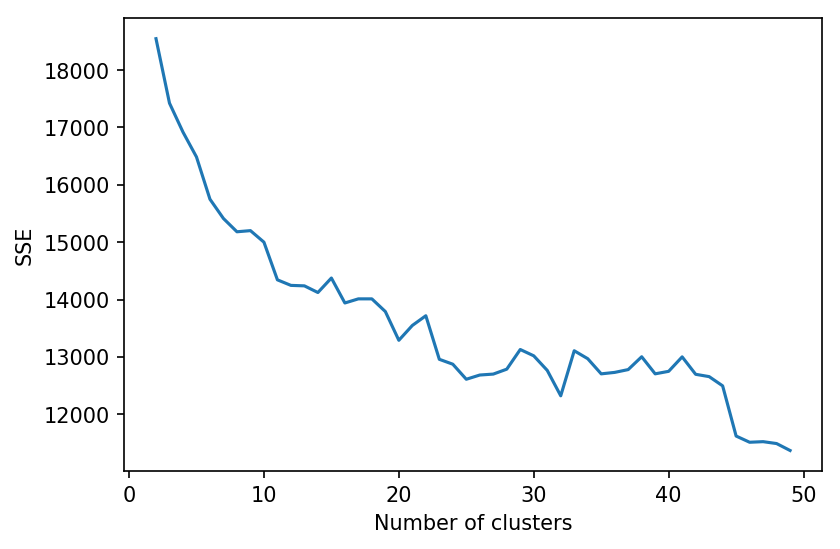

In [9]:
SSEs = []
silhouettes = []
for k in range(2,50):
    km = MiniBatchKMeans(n_clusters=k, random_state=2)
    km.fit(inclusion_df)
    labels = km.labels_
    SSEs.append(km.inertia_) 
    silhouettes.append(silhouette_score(inclusion_df, labels))
    
plt.figure(dpi=150)    
plt.xlabel("Number of clusters")  
plt.ylabel("SSE")
plt.plot(range(2,50), SSEs);

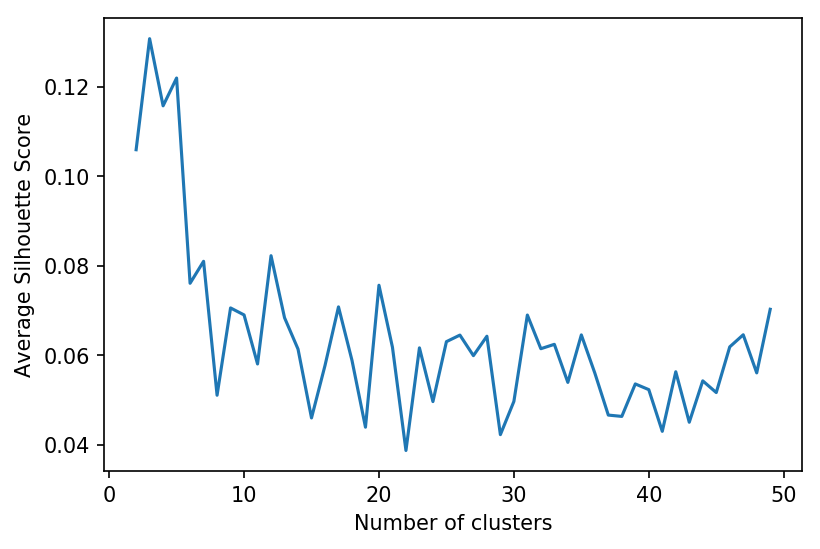

In [13]:
plt.figure(dpi=150)    
plt.xlabel("Number of clusters")  
plt.ylabel("Average Silhouette Score")
plt.plot(range(2,50), silhouettes);

## Clustering on the reduced 2-D PC space: k-Means sandbox example just to visualize it

No need to scale the data because it's on the same scale (dimension-reduced vectorized criteria)

In [14]:
km = MiniBatchKMeans(n_clusters=3)
clusts = km.fit_predict(reduced_2D_vectors)

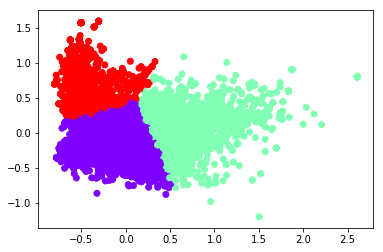

In [15]:
plt.scatter(reduced_2D_vectors[:,0], reduced_2D_vectors[:,1], c=clusts, cmap=plt.cm.rainbow);

## 86-dim k-Means 

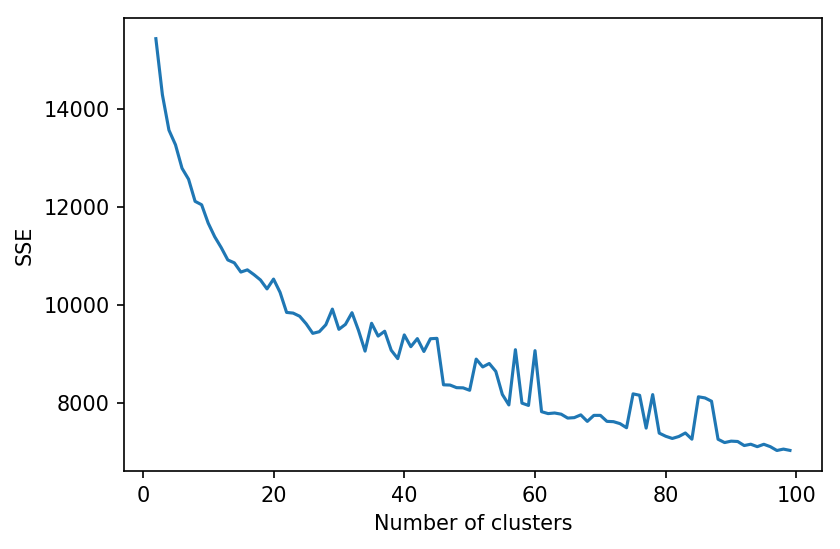

In [50]:
SSEs = []
silhouettes = []
for k in range(2,100):
    km = MiniBatchKMeans(n_clusters=k, random_state=2)
    km.fit(reduced_86D_vectors)
    labels = km.labels_
    SSEs.append(km.inertia_) 
    silhouettes.append(silhouette_score(reduced_86D_vectors, labels))
    
plt.figure(dpi=150)    
plt.xlabel("Number of clusters")  
plt.ylabel("SSE")
plt.plot(range(2,100), SSEs);

### Match cluster labels to individual criteria in 86-dim space

Link 'winning' cluster labels to individual criteria and studies.

Need to grab study ids from the database because I didn't store it locally =/. Build this into the data cleaning earlier so I collect a list of studies to match back to the inclusion vectors later on.

In [52]:
def connect_to_mongo(database, collection):
    
    """
    Opens a connection to a specified Mongo DB location
    
    Input Parameters:
    database: name of database to connect to or create (str)
    collection: name of collection to connect to or create (str)
    
    Returns:
    The connection object for the database without a collection specified
    The connection object for a specific Mongo location (database & collection)
    """
    
    client = MongoClient()
    db = client[database]
    mongo_loc = db[collection]
    return db, mongo_loc

In [53]:
trials_loc, eligibility_loc = connect_to_mongo('clinical_trials', 'eligibilities')

In [54]:
doc_cursor = eligibility_loc.find({"inclusion_criteria": { '$regex' : ".*asthma.*"}})

study_id = []
inclusion_text = []

for study in doc_cursor:
    for crit in study['cleaned_inclusion']:
        study_id.append(study['study_id'])
        inclusion_text.append(crit)
print(len(study_id))

11298


In [107]:
pickle.dump(inclusion_text, open("inclusion_text.p", "wb"))

In [106]:
pickle.dump(study_id, open("study_id.p", "wb"))

In [62]:
len(labels)

11235

Remove study ids from criteria that were dropped due to having NaN

In [56]:
drop_row_list = pickle.load(open("drop_row_list.p", 'rb'))

In [57]:
for i in sorted(drop_row_list, reverse=True):
    del study_id[i]
    del inclusion_text[i]

In [58]:
len(np.unique(study_id))

2155

In [59]:
len(study_id)

11235

In [60]:
len(inclusion_text)

11235

In [63]:
clusts = labels.reshape(11235, 1)
clusts

array([[48],
       [78],
       [61],
       ..., 
       [10],
       [72],
       [79]], dtype=int32)

In [64]:
studies = np.array(study_id)
studies = studies.reshape(11235, 1)

In [65]:
crit_studies_clusters = np.hstack((clusts, studies))
print(crit_studies_clusters)

[['48' 'NCT00861185']
 ['78' 'NCT00861185']
 ['61' 'NCT00861185']
 ..., 
 ['10' 'NCT00867737']
 ['72' 'NCT00867737']
 ['79' 'NCT00867737']]


In [66]:
crit_df = pd.DataFrame(crit_studies_clusters)
crit_df.columns = ['cluster', 'study_id']

In [67]:
crit_df.head()

,cluster,study_id
0,48,NCT00861185
1,78,NCT00861185
2,61,NCT00861185
3,72,NCT00861185
4,97,NCT00861185


## Format for network plot with criteria as nodes: 86-dim

In [68]:
crit_group = crit_df.groupby(by='study_id')['cluster'].apply(tuple)

In [69]:
crit_network_input = np.array(crit_group)

In [70]:
crit_network_input

array([('80', '87', '3', '95', '63', '41', '21', '4', '57'),
       ('77', '61', '26', '55', '80', '54', '49'),
       ('55', '49', '17', '66', '95', '69', '35'), ..., ('66', '29'),
       ('91', '80', '12', '31', '49'),
       ('16', '19', '49', '47', '47', '50', '43', '78', '60', '32', '98', '85', '12', '49', '84', '98', '98', '36')], dtype=object)

In [71]:
combinations(crit_network_input[0], 2)

In [72]:
network_input = []
for crit in crit_network_input:
    results = [x for x in combinations(crit, 2)]
    network_input += (results)

In [73]:
len(network_input)

38465

In [74]:
network_input[:10]

[('80', '87'),
 ('80', '3'),
 ('80', '95'),
 ('80', '63'),
 ('80', '41'),
 ('80', '21'),
 ('80', '4'),
 ('80', '57'),
 ('87', '3'),
 ('87', '95')]

## Make network plot: nodes are eligibility criteria

In [75]:
trials = nx.Graph()

In [76]:
for crit_1, crit_2 in network_input:
    trials.add_edge(crit_1, crit_2)

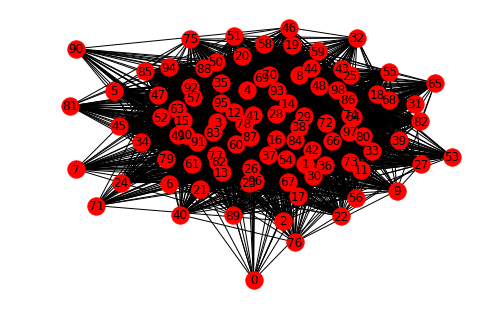

In [77]:
positions = nx.spring_layout(trials)
network = nx.draw(trials, pos=positions)
labels =  nx.draw_networkx_labels(trials, pos=positions)

In [78]:
nx.density(trials)

0.7567511853226139

In [79]:
nx.degree(trials)

DegreeView({'80': 84, '87': 98, '3': 98, '95': 94, '63': 81, '41': 92, '21': 72, '4': 95, '57': 90, '77': 96, '61': 93, '26': 94, '55': 58, '54': 95, '49': 90, '17': 73, '66': 91, '69': 88, '35': 80, '56': 57, '70': 85, '37': 94, '60': 98, '88': 70, '36': 97, '96': 92, '14': 89, '91': 90, '15': 88, '78': 93, '42': 95, '12': 98, '72': 94, '28': 97, '31': 64, '44': 62, '83': 90, '98': 88, '2': 43, '13': 85, '52': 86, '59': 72, '16': 95, '84': 96, '68': 65, '38': 96, '18': 76, '75': 57, '29': 95, '64': 85, '39': 76, '34': 73, '1': 84, '33': 80, '23': 82, '81': 39, '8': 84, '25': 77, '11': 81, '97': 79, '43': 80, '10': 84, '93': 83, '79': 83, '86': 86, '62': 76, '92': 76, '40': 46, '32': 47, '47': 72, '73': 77, '74': 78, '71': 29, '19': 67, '46': 48, '58': 59, '6': 65, '20': 71, '51': 52, '94': 70, '27': 53, '9': 47, '67': 72, '85': 55, '45': 62, '89': 55, '30': 77, '5': 52, '50': 74, '7': 37, '48': 72, '53': 39, '22': 49, '90': 29, '24': 48, '65': 52, '82': 61, '76': 31, '0': 19})

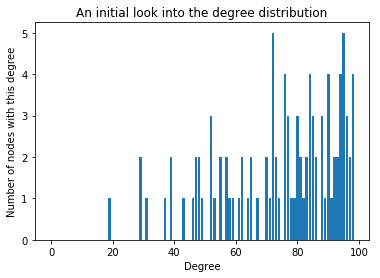

In [80]:
degree_hist = nx.degree_histogram(trials)
xticks = range(len(degree_hist))
plt.bar(xticks, degree_hist, align='center')
plt.xlabel('Degree')
plt.ylabel('Number of nodes with this degree')
plt.title('An initial look into the degree distribution');

## Format for network plot with studies as nodes 

In [81]:
crit_group_study_node = crit_df.groupby(by='cluster')['study_id'].apply(tuple)

In [82]:
crit_network_input_study_node = np.array(crit_group_study_node)

In [83]:
network_input_study_nodes = []
for crit in crit_network_input_study_node:
    results = [x for x in combinations(crit, 2)]
    network_input_study_nodes += (results)

In [84]:
network_input_study_nodes[:5]

[('NCT02824523', 'NCT01918293'),
 ('NCT02824523', 'NCT02064738'),
 ('NCT02824523', 'NCT01963741'),
 ('NCT02824523', 'NCT01543516'),
 ('NCT02824523', 'NCT01305369')]

### Identifying communities in the criteria network 

In [85]:
modules = community.best_partition(trials)

In [86]:
module_ids = set(modules.values())
num_modules = len(module_ids)
num_modules

5

### Identify which criteria are in each community

In [88]:
module_to_nodes = defaultdict(list)
for node, module_id in modules.items():
    module_to_nodes[module_id].append(node)

# module_to_nodes[4]

### Plot the criteria network graph with communities 

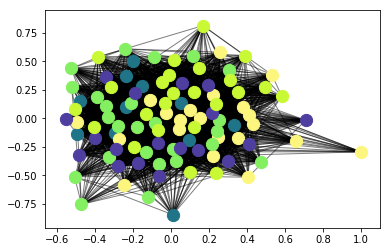

In [89]:
positions = nx.spring_layout(trials)

rand_color = randomcolor.RandomColor()
colors = rand_color.generate(count=num_modules)
for i, module in enumerate(module_ids):
    nodes_in_this_module = module_to_nodes[module]
    module_color = colors[i % len(colors)]
    nx.draw_networkx_nodes(trials,
                           positions,
                           nodes_in_this_module,
                           node_color = module_color,
                           node_size = 150)
nx.draw_networkx_edges(trials, positions, alpha=0.5)
# labels =  nx.draw_networkx_labels(study_nodes, pos=positions)

## Network graph: trials as nodes 

In [95]:
# study_nodes = nx.Graph()

In [96]:
# for trial_1, trial_2 in network_input_study_nodes:
#     study_nodes.add_edge(trial_1, trial_2)

In [90]:
default_weight = 1
study_nodes = nx.Graph()
for nodes in network_input_study_nodes:
    n0 = nodes[0]
    n1 = nodes[1]
    if study_nodes.has_edge(n0,n1):   
        study_nodes[n0][n1]['weight'] += default_weight
    else:
        study_nodes.add_edge(n0,n1, weight=default_weight)

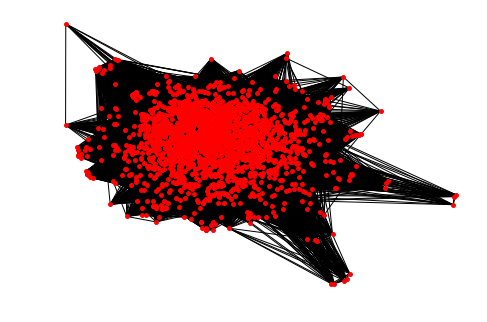

In [91]:
positions = nx.spring_layout(study_nodes)
network = nx.draw(study_nodes, pos=positions, node_size = 15)
# labels =  nx.draw_networkx_labels(study_nodes, pos=positions)

In [92]:
nx.write_gexf(study_nodes, "86D_kMeans.gexf")

In [93]:
neighbor_weights = study_nodes['NCT00862394']

In [94]:
# print(neighbor_weights)

In [95]:
nx.density(study_nodes)

0.2993970102566423

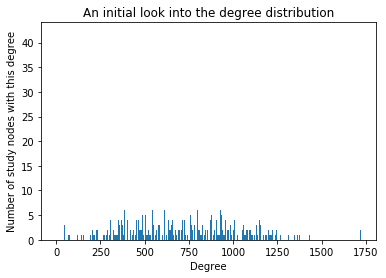

In [96]:
degree_hist = nx.degree_histogram(study_nodes)
xticks = range(len(degree_hist)) # adjust range and widths
plt.bar(xticks, degree_hist, align='center')
plt.xlabel('Degree')
plt.ylabel('Number of study nodes with this degree')
plt.title('An initial look into the degree distribution');

### Identifying communities in the network 

In [97]:
modules = community.best_partition(study_nodes)

In [98]:
module_ids = set(modules.values())
num_modules = len(module_ids)
num_modules

6

### Identify which criteria are in each community

In [99]:
module_to_nodes = defaultdict(list)
for node, module_id in modules.items():
    module_to_nodes[module_id].append(node)

# module_to_nodes[0]

### Plot the criteria network graph with communities 

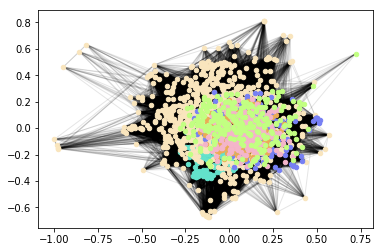

In [100]:
positions = nx.spring_layout(study_nodes)

rand_color = randomcolor.RandomColor()
colors = rand_color.generate(hue='random', count=num_modules)
for i, module in enumerate(module_ids):
    nodes_in_this_module = module_to_nodes[module]
    module_color = colors[i % len(colors)]
    nx.draw_networkx_nodes(trials,
                           positions,
                           nodes_in_this_module,
                           node_color = module_color,
                           node_size = 20)
nx.draw_networkx_edges(study_nodes, positions, alpha=0.1)
# labels =  nx.draw_networkx_labels(study_nodes, pos=positions)

In [101]:
nx.write_gexf(study_nodes, "86D_kMeans_trial_nodes.gexf")